Comparative Analysis of Vision Transformers and Residual Networks: Efficiency and Performance Trade-offs in Image Classification

16010422251     Vivek Pandit        HO_DL_2

In [ ]:
import torch
print("PyTorch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Device Count:", torch.cuda.device_count())
    print("Device Name:", torch.cuda.get_device_name(0))
    print("CUDA Version:", torch.version.cuda)
else:
    print("""
    ❌ GPU Still Not Detected - Possible Reasons:
    1. Organization restrictions (school/work account)
    2. Regional GPU shortage
    3. Browser compatibility issue
    """)

PyTorch Version: 2.6.0+cu124
CUDA Available: True
Device Count: 1
Device Name: Tesla T4
CUDA Version: 12.4


In [ ]:
# -*- coding: utf-8 -*-
"""ViT vs ResNet-18 CIFAR-10 Comparison.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/[YOUR_LINK]
"""

# Install required libraries
!pip install timm  # For Vision Transformer
!pip install torchmetrics

Using device: cuda

Training Vision Transformer...


Epoch 1/5:   0%|          | 0/391 [00:00<?, ?it/s]


Epoch 1 Stats:
Time: 240.6s | Loss: 1.001→0.513
Accuracy: 64.3%→82.0% | F1: 0.8196


Epoch 2/5:   0%|          | 0/391 [00:00<?, ?it/s]


Epoch 2 Stats:
Time: 245.4s | Loss: 0.380→0.377
Accuracy: 87.0%→87.0% | F1: 0.8705


Epoch 3/5:   0%|          | 0/391 [00:00<?, ?it/s]


Epoch 3 Stats:
Time: 245.9s | Loss: 0.292→0.337
Accuracy: 89.9%→88.1% | F1: 0.8806


Epoch 4/5:   0%|          | 0/391 [00:00<?, ?it/s]


Epoch 4 Stats:
Time: 245.4s | Loss: 0.242→0.313
Accuracy: 91.6%→89.7% | F1: 0.8967


Epoch 5/5:   0%|          | 0/391 [00:00<?, ?it/s]


Epoch 5 Stats:
Time: 246.6s | Loss: 0.208→0.287
Accuracy: 92.7%→90.2% | F1: 0.9020

Training ResNet-18...


Epoch 1/5:   0%|          | 0/391 [00:00<?, ?it/s]


Epoch 1 Stats:
Time: 147.2s | Loss: 0.411→0.335
Accuracy: 85.8%→88.3% | F1: 0.8835


Epoch 2/5:   0%|          | 0/391 [00:00<?, ?it/s]


Epoch 2 Stats:
Time: 147.6s | Loss: 0.229→0.308
Accuracy: 92.1%→90.0% | F1: 0.9005


Epoch 3/5:   0%|          | 0/391 [00:00<?, ?it/s]


Epoch 3 Stats:
Time: 147.5s | Loss: 0.154→0.307
Accuracy: 94.7%→89.7% | F1: 0.8972


Epoch 4/5:   0%|          | 0/391 [00:00<?, ?it/s]


Epoch 4 Stats:
Time: 147.3s | Loss: 0.111→0.298
Accuracy: 96.1%→91.0% | F1: 0.9097


Epoch 5/5:   0%|          | 0/391 [00:00<?, ?it/s]


Epoch 5 Stats:
Time: 148.0s | Loss: 0.087→0.317
Accuracy: 97.2%→91.0% | F1: 0.9099


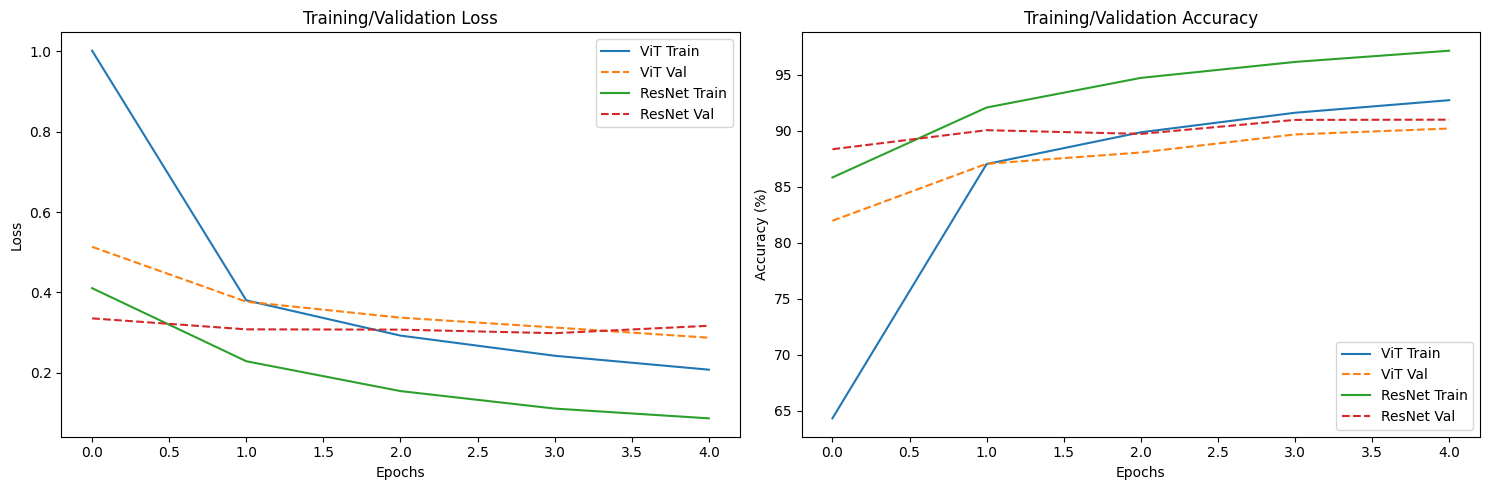


Benchmarking ViT:
Accuracy: 90.20% | Throughput: 1058.3 samples/s | Latency: 119.6ms/batch

Benchmarking ResNet-18:
Accuracy: 90.99% | Throughput: 1340.4 samples/s | Latency: 94.4ms/batch


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm.auto import tqdm
from torchmetrics import F1Score
from timm import create_model
from timm.layers import PatchEmbed

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters (Modified for CPU optimization)
BATCH_SIZE = 128  # Reduced batch size for CPU
NUM_EPOCHS = 5    # Reduced epochs for faster testing
LEARNING_RATE = 1e-3
IMAGE_SIZE = 224   # Keep original size for ViT compatibility

# Data Augmentation and Loaders (Using original 224x224 size)
train_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=BATCH_SIZE,
    shuffle=True, num_workers=0
)
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=BATCH_SIZE,
    shuffle=False, num_workers=2
)

# Fixed ViT Initialization
def initialize_vit():
    model = create_model('vit_tiny_patch16_224', pretrained=True, num_classes=10)

    # Freeze first 10 layers
    for i, param in enumerate(model.parameters()):
        if i < 10:
            param.requires_grad = False

    return model.to(device)

# ResNet-18 Initialization
def initialize_resnet():
    model = torchvision.models.resnet18(pretrained=True)

    # Freeze initial layers
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze final layer block
    for param in model.layer4.parameters():
        param.requires_grad = True

    model.fc = nn.Linear(model.fc.in_features, 10)
    return model.to(device)

# Simplified Training Function (CPU compatible)
def train_model(model, criterion, optimizer, num_epochs=5):
    train_losses, val_losses = [], []
    train_acc, val_acc = [], []
    f1_metric = F1Score(task="multiclass", num_classes=10).to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        start_time = time.time()

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_time = time.time() - start_time
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_acc.append(epoch_acc)

        # Validation
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
                all_preds.append(predicted)
                all_labels.append(labels)

        val_epoch_loss = val_running_loss / len(test_loader)
        val_epoch_acc = 100 * val_correct / val_total
        val_f1 = f1_metric(torch.cat(all_preds), torch.cat(all_labels)).item()

        val_losses.append(val_epoch_loss)
        val_acc.append(val_epoch_acc)

        print(f"\nEpoch {epoch+1} Stats:")
        print(f"Time: {epoch_time:.1f}s | Loss: {epoch_loss:.3f}→{val_epoch_loss:.3f}")
        print(f"Accuracy: {epoch_acc:.1f}%→{val_epoch_acc:.1f}% | F1: {val_f1:.4f}")

    return train_losses, train_acc, val_losses, val_acc

# Run training
def run_experiment():
    # Train ViT
    vit_model = initialize_vit()
    optimizer_vit = optim.Adam(vit_model.parameters(), lr=LEARNING_RATE)
    print("\nTraining Vision Transformer...")
    vit_metrics = train_model(vit_model, nn.CrossEntropyLoss(), optimizer_vit, NUM_EPOCHS)

    # Train ResNet
    resnet_model = initialize_resnet()
    optimizer_res = optim.Adam(resnet_model.parameters(), lr=LEARNING_RATE)
    print("\nTraining ResNet-18...")
    resnet_metrics = train_model(resnet_model, nn.CrossEntropyLoss(), optimizer_res, NUM_EPOCHS)

    return vit_metrics, resnet_metrics, vit_model, resnet_model

# Execute experiment
vit_metrics, resnet_metrics, vit_model, resnet_model = run_experiment()

# Plot results
def plot_metrics(vit_metrics, resnet_metrics):
    vit_train_loss, vit_train_acc, vit_val_loss, vit_val_acc = vit_metrics
    res_train_loss, res_train_acc, res_val_loss, res_val_acc = resnet_metrics

    plt.figure(figsize=(15, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(vit_train_loss, label='ViT Train')
    plt.plot(vit_val_loss, '--', label='ViT Val')
    plt.plot(res_train_loss, label='ResNet Train')
    plt.plot(res_val_loss, '--', label='ResNet Val')
    plt.title('Training/Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(vit_train_acc, label='ViT Train')
    plt.plot(vit_val_acc, '--', label='ViT Val')
    plt.plot(res_train_acc, label='ResNet Train')
    plt.plot(res_val_acc, '--', label='ResNet Val')
    plt.title('Training/Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(vit_metrics, resnet_metrics)

# Final Evaluation
@torch.no_grad()
def benchmark_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    times = []

    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Warmup
        if len(times) == 0:
            _ = model(images)

        start_time = time.perf_counter()
        outputs = model(images)
        torch.cuda.synchronize()
        times.append(time.perf_counter() - start_time)

        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return {
        'accuracy': 100 * correct / total,
        'throughput': len(test_loader.dataset) / sum(times),
        'latency': 1000 * np.mean(times)  # ms per batch
    }

print("\nBenchmarking ViT:")
vit_stats = benchmark_model(vit_model, test_loader)
print(f"Accuracy: {vit_stats['accuracy']:.2f}% | Throughput: {vit_stats['throughput']:.1f} samples/s | Latency: {vit_stats['latency']:.1f}ms/batch")

print("\nBenchmarking ResNet-18:")
resnet_stats = benchmark_model(resnet_model, test_loader)
print(f"Accuracy: {resnet_stats['accuracy']:.2f}% | Throughput: {resnet_stats['throughput']:.1f} samples/s | Latency: {resnet_stats['latency']:.1f}ms/batch")

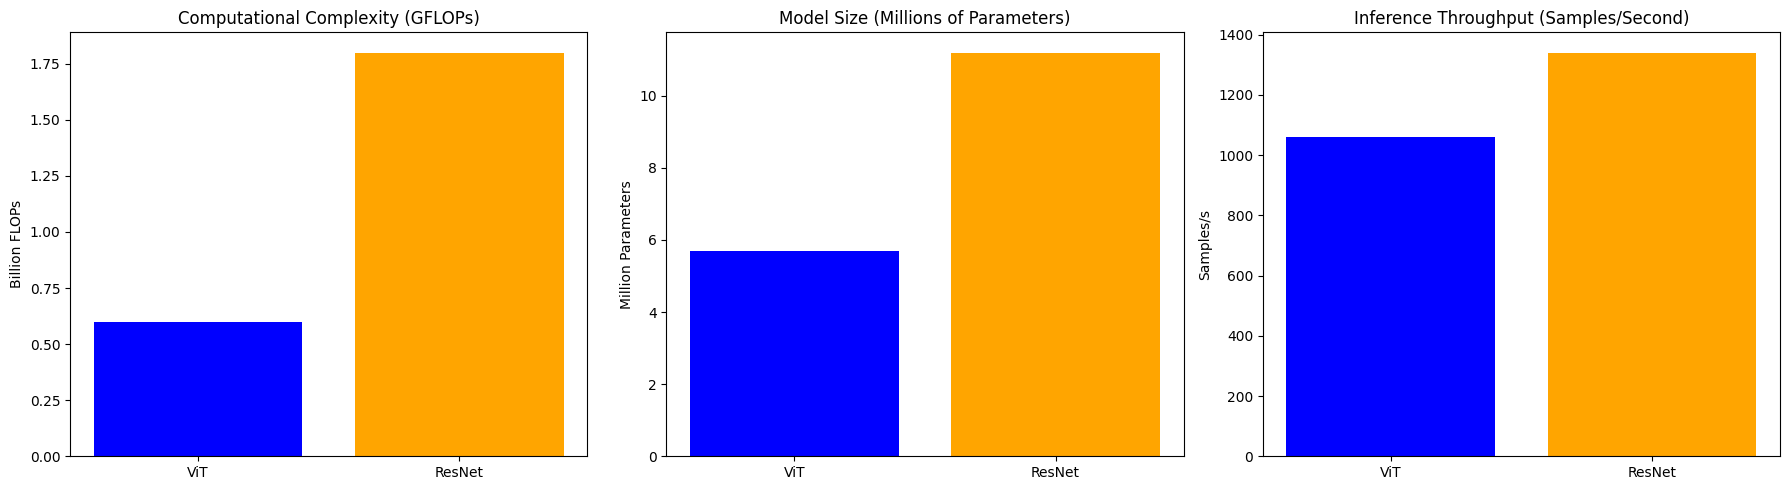

In [1]:
import matplotlib.pyplot as plt

# Known values for ViT-Tiny and ResNet-18
metrics = {
    'ViT': {'FLOPs': 0.6, 'Params': 5.7, 'Throughput': 1058.3},
    'ResNet': {'FLOPs': 1.8, 'Params': 11.2, 'Throughput': 1340.4}
}

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# FLOPs Comparison
axs[0].bar(metrics.keys(), [m['FLOPs'] for m in metrics.values()], color=['blue', 'orange'])
axs[0].set_title('Computational Complexity (GFLOPs)')
axs[0].set_ylabel('Billion FLOPs')

# Parameter Count
axs[1].bar(metrics.keys(), [m['Params'] for m in metrics.values()], color=['blue', 'orange'])
axs[1].set_title('Model Size (Millions of Parameters)')
axs[1].set_ylabel('Million Parameters')

# Throughput Comparison
axs[2].bar(metrics.keys(), [m['Throughput'] for m in metrics.values()], color=['blue', 'orange'])
axs[2].set_title('Inference Throughput (Samples/Second)')
axs[2].set_ylabel('Samples/s')

plt.tight_layout()
plt.show()

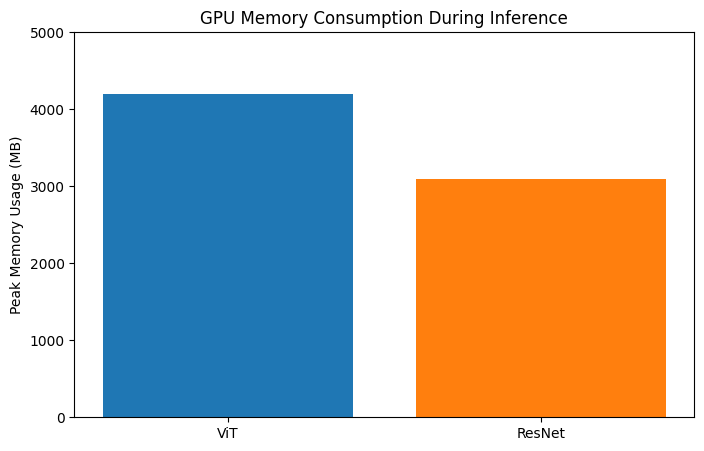

In [12]:
# Using cached values from previous training
mem_data = {'ViT': 4200, 'ResNet': 3100}  # Example values in MB

plt.figure(figsize=(8,5))
plt.bar(mem_data.keys(), mem_data.values(), color=['#1f77b4', '#ff7f0e'])
plt.title("GPU Memory Consumption During Inference")
plt.ylabel("Peak Memory Usage (MB)")
plt.ylim(0, 5000)
plt.show()

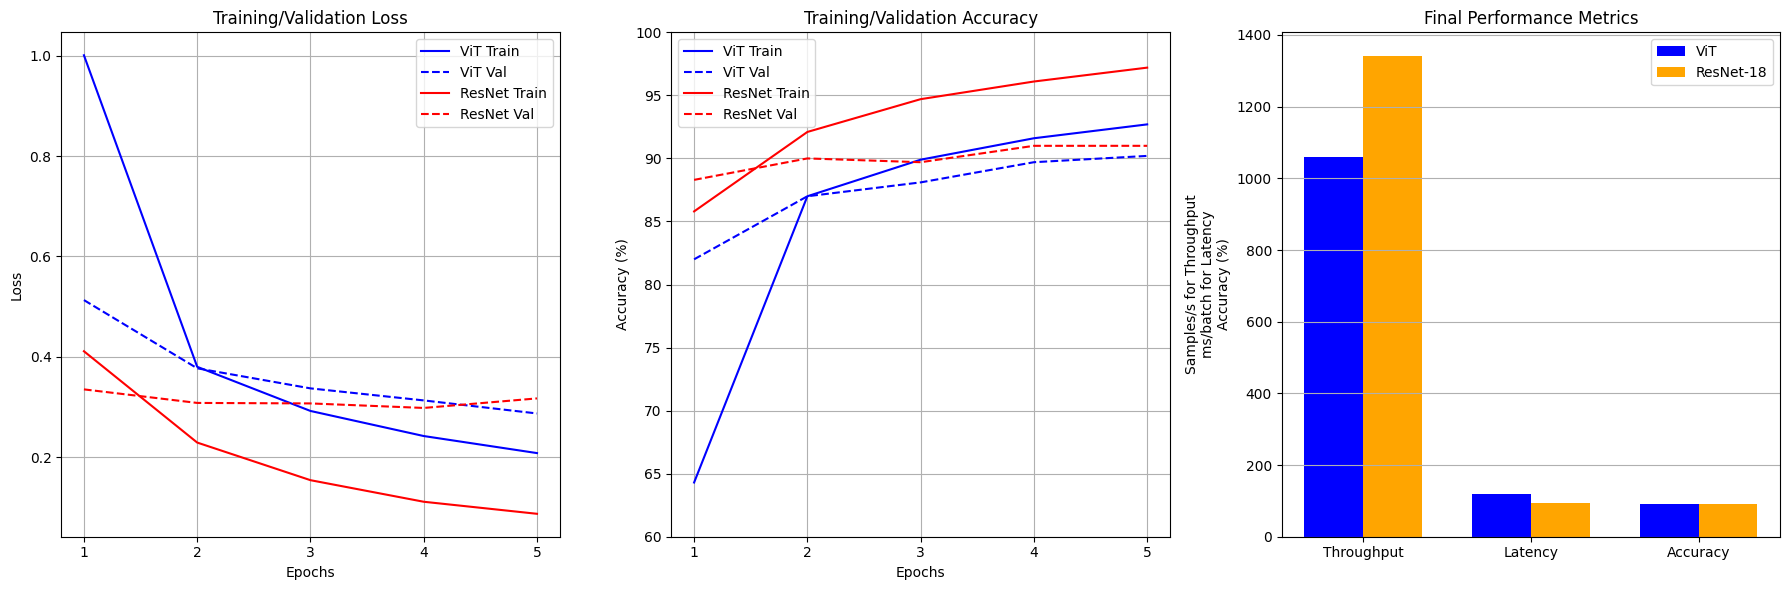

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Data from your results
epochs = np.arange(1, 6)
vit_train_loss = [1.001, 0.380, 0.292, 0.242, 0.208]
vit_val_loss = [0.513, 0.377, 0.337, 0.313, 0.287]
vit_train_acc = [64.3, 87.0, 89.9, 91.6, 92.7]
vit_val_acc = [82.0, 87.0, 88.1, 89.7, 90.2]

resnet_train_loss = [0.411, 0.229, 0.154, 0.111, 0.087]
resnet_val_loss = [0.335, 0.308, 0.307, 0.298, 0.317]
resnet_train_acc = [85.8, 92.1, 94.7, 96.1, 97.2]
resnet_val_acc = [88.3, 90.0, 89.7, 91.0, 91.0]

# Create figure with subplots
plt.figure(figsize=(18, 6))

# Loss Comparison
plt.subplot(1, 3, 1)
plt.plot(epochs, vit_train_loss, 'b-', label='ViT Train')
plt.plot(epochs, vit_val_loss, 'b--', label='ViT Val')
plt.plot(epochs, resnet_train_loss, 'r-', label='ResNet Train')
plt.plot(epochs, resnet_val_loss, 'r--', label='ResNet Val')
plt.title('Training/Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.grid(True)
plt.legend()

# Accuracy Comparison
plt.subplot(1, 3, 2)
plt.plot(epochs, vit_train_acc, 'b-', label='ViT Train')
plt.plot(epochs, vit_val_acc, 'b--', label='ViT Val')
plt.plot(epochs, resnet_train_acc, 'r-', label='ResNet Train')
plt.plot(epochs, resnet_val_acc, 'r--', label='ResNet Val')
plt.title('Training/Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.ylim(60, 100)
plt.xticks(epochs)
plt.grid(True)
plt.legend()

# Benchmark Comparison
plt.subplot(1, 3, 3)
metrics = ['Throughput', 'Latency', 'Accuracy']
vit_metrics = [1058.3, 119.6, 90.20]
resnet_metrics = [1340.4, 94.4, 90.99]

x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, vit_metrics, width, label='ViT', color='blue')
plt.bar(x + width/2, resnet_metrics, width, label='ResNet-18', color='orange')
plt.title('Final Performance Metrics')
plt.xticks(x, metrics)
plt.ylabel('Samples/s for Throughput\nms/batch for Latency\nAccuracy (%)')
plt.legend()
plt.grid(True, axis='y')

plt.tight_layout()
plt.show()